1. Ustalenie zakresu danych 

2. Pobranie zdjęć z koordynatami

a) pobranie informacji o zdjęciach z bazy danych Sloan Digital Sky Survey (SDSS) za pomocą SDSS Query / CasJobs (https://skyserver.sdss.org/CasJobs/SubmitJob.aspx) do pliku csv

Poniższe zapytanie pobiera pierwsze 1000 obiektów z koordynatami i informacjami potrzebnymi do pobrania zdjęć.

![alt text](sdss_query.png "SDSS Query")

In [1]:
import pandas as pd
df = pd.read_csv("C:/Python_Marta/astro_project/image_list.csv")
df.head()

,objid,ra,dec,run,rerun,camcol,field
0,1237676302422379175,96.356700,6.654021,7178,301,1,206
1,1237676302411825797,75.012809,-4.752014,7178,301,1,45
2,1237676302414185026,79.756687,-2.216747,7178,301,1,81
3,1237676302422705529,96.900687,7.113349,7178,301,1,211
4,1237676302412743368,76.890922,-3.724654,7178,301,1,59


b) pobranie zdjęć na podstawie listy koordynatów ze strony skyserver.sdss.org

In [2]:
import requests
import csv

def fetch_sdss_image(ra, dec, run, rerun, camcol, field, scale=0.2, width=512, height=512):
    url = f"http://skyserver.sdss.org/dr16/SkyServerWS/ImgCutout/getjpeg?ra={ra}&dec={dec}&scale={scale}&width={width}&height={height}&opt=G"
    response = requests.get(url)
    if response.status_code == 200:
        filename = f"sdss_image_{ra}_{dec}.jpg"
        with open(filename, "wb") as file:
            file.write(response.content)

# wczytanie danych z pliku CSV
#with open('image_list.csv', newline='') as csvfile:
#    reader = csv.DictReader(csvfile)
#    for row in reader:
#        fetch_sdss_image(row['ra'], row['dec'], row['run'], row['rerun'], row['camcol'], row['field'])

3. Wczytywanie i przetwarzanie obrazów

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from astropy.wcs import WCS

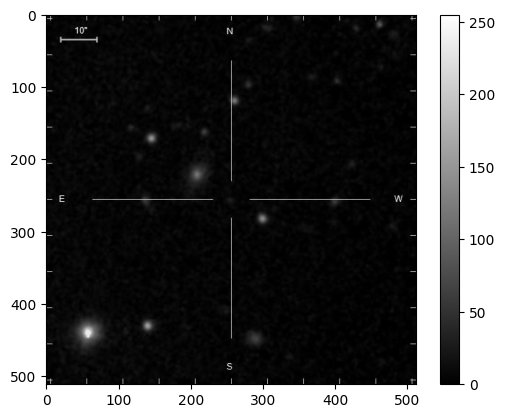

In [109]:
# Wczytywanie obrazu JPG
file_path = "C:/Python_Marta/astro_project/images/sdss_image_70.6151118613413_-7.19478565428007.jpg"

# Odczyt obrazu za pomocą OpenCV
image_data = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

plt.imshow(image_data, cmap='gray')
plt.colorbar()
plt.show()

4. Identyfikacja gwiazd

In [116]:
def find_stars(image_data):
    # Normalizacja obrazu
    norm_image = cv2.normalize(image_data, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    
    # Przetwarzanie obrazu
    blur = cv2.GaussianBlur(norm_image, (11, 11), 0)
    # Wyznaczenie progu, żeby nie były brane pod uwagę oznaczenia wykresu
    _, thresholded = cv2.threshold(blur, 100, 255, cv2.THRESH_BINARY)
    
    # Znalezienie konturów gwiazd
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    stars = []
    for cnt in contours:
        # Filtrowanie konturów na podstawie ich rozmiaru
        area = cv2.contourArea(cnt)
        if 5 < area < 500:  
            perimeter = cv2.arcLength(cnt, True)
            if perimeter == 0:
                continue
            # Wyyznaczenie środka gwiazdy
            M = cv2.moments(cnt)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                stars.append((cX, cY))
    
    return stars

stars = find_stars(image_data)



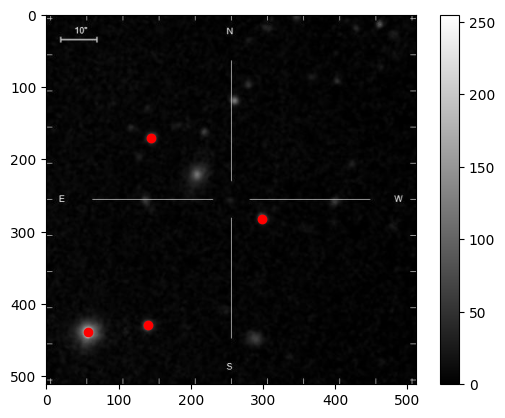

In [119]:
# Wyświetlenie obrazu z zaznaczonymi gwiazdami
plt.imshow(image_data, cmap='gray')
plt.colorbar()
for (x, y) in stars:
    plt.plot(x, y, 'ro')
plt.show()